In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from dataloader import fishingDataLoader


/Users/marvinraschke/.local/share/virtualenvs/fishingNN-j66MMPMR/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = fishingDataLoader()
ship_group = data.genDatasetFromTrips(sample=6000)

unique mms's: 6
9
9
6


/Users/marvinraschke/.local/share/virtualenvs/fishingNN-j66MMPMR/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
summe = 0
trips = 0
for ship in ship_group:
    for trip in ship:
        trips += 1
        summe += len(trip)

print(f"insgesamt {summe} Datensätze in {trips} trips")

insgesamt 29495 Datensätze in 24 trips


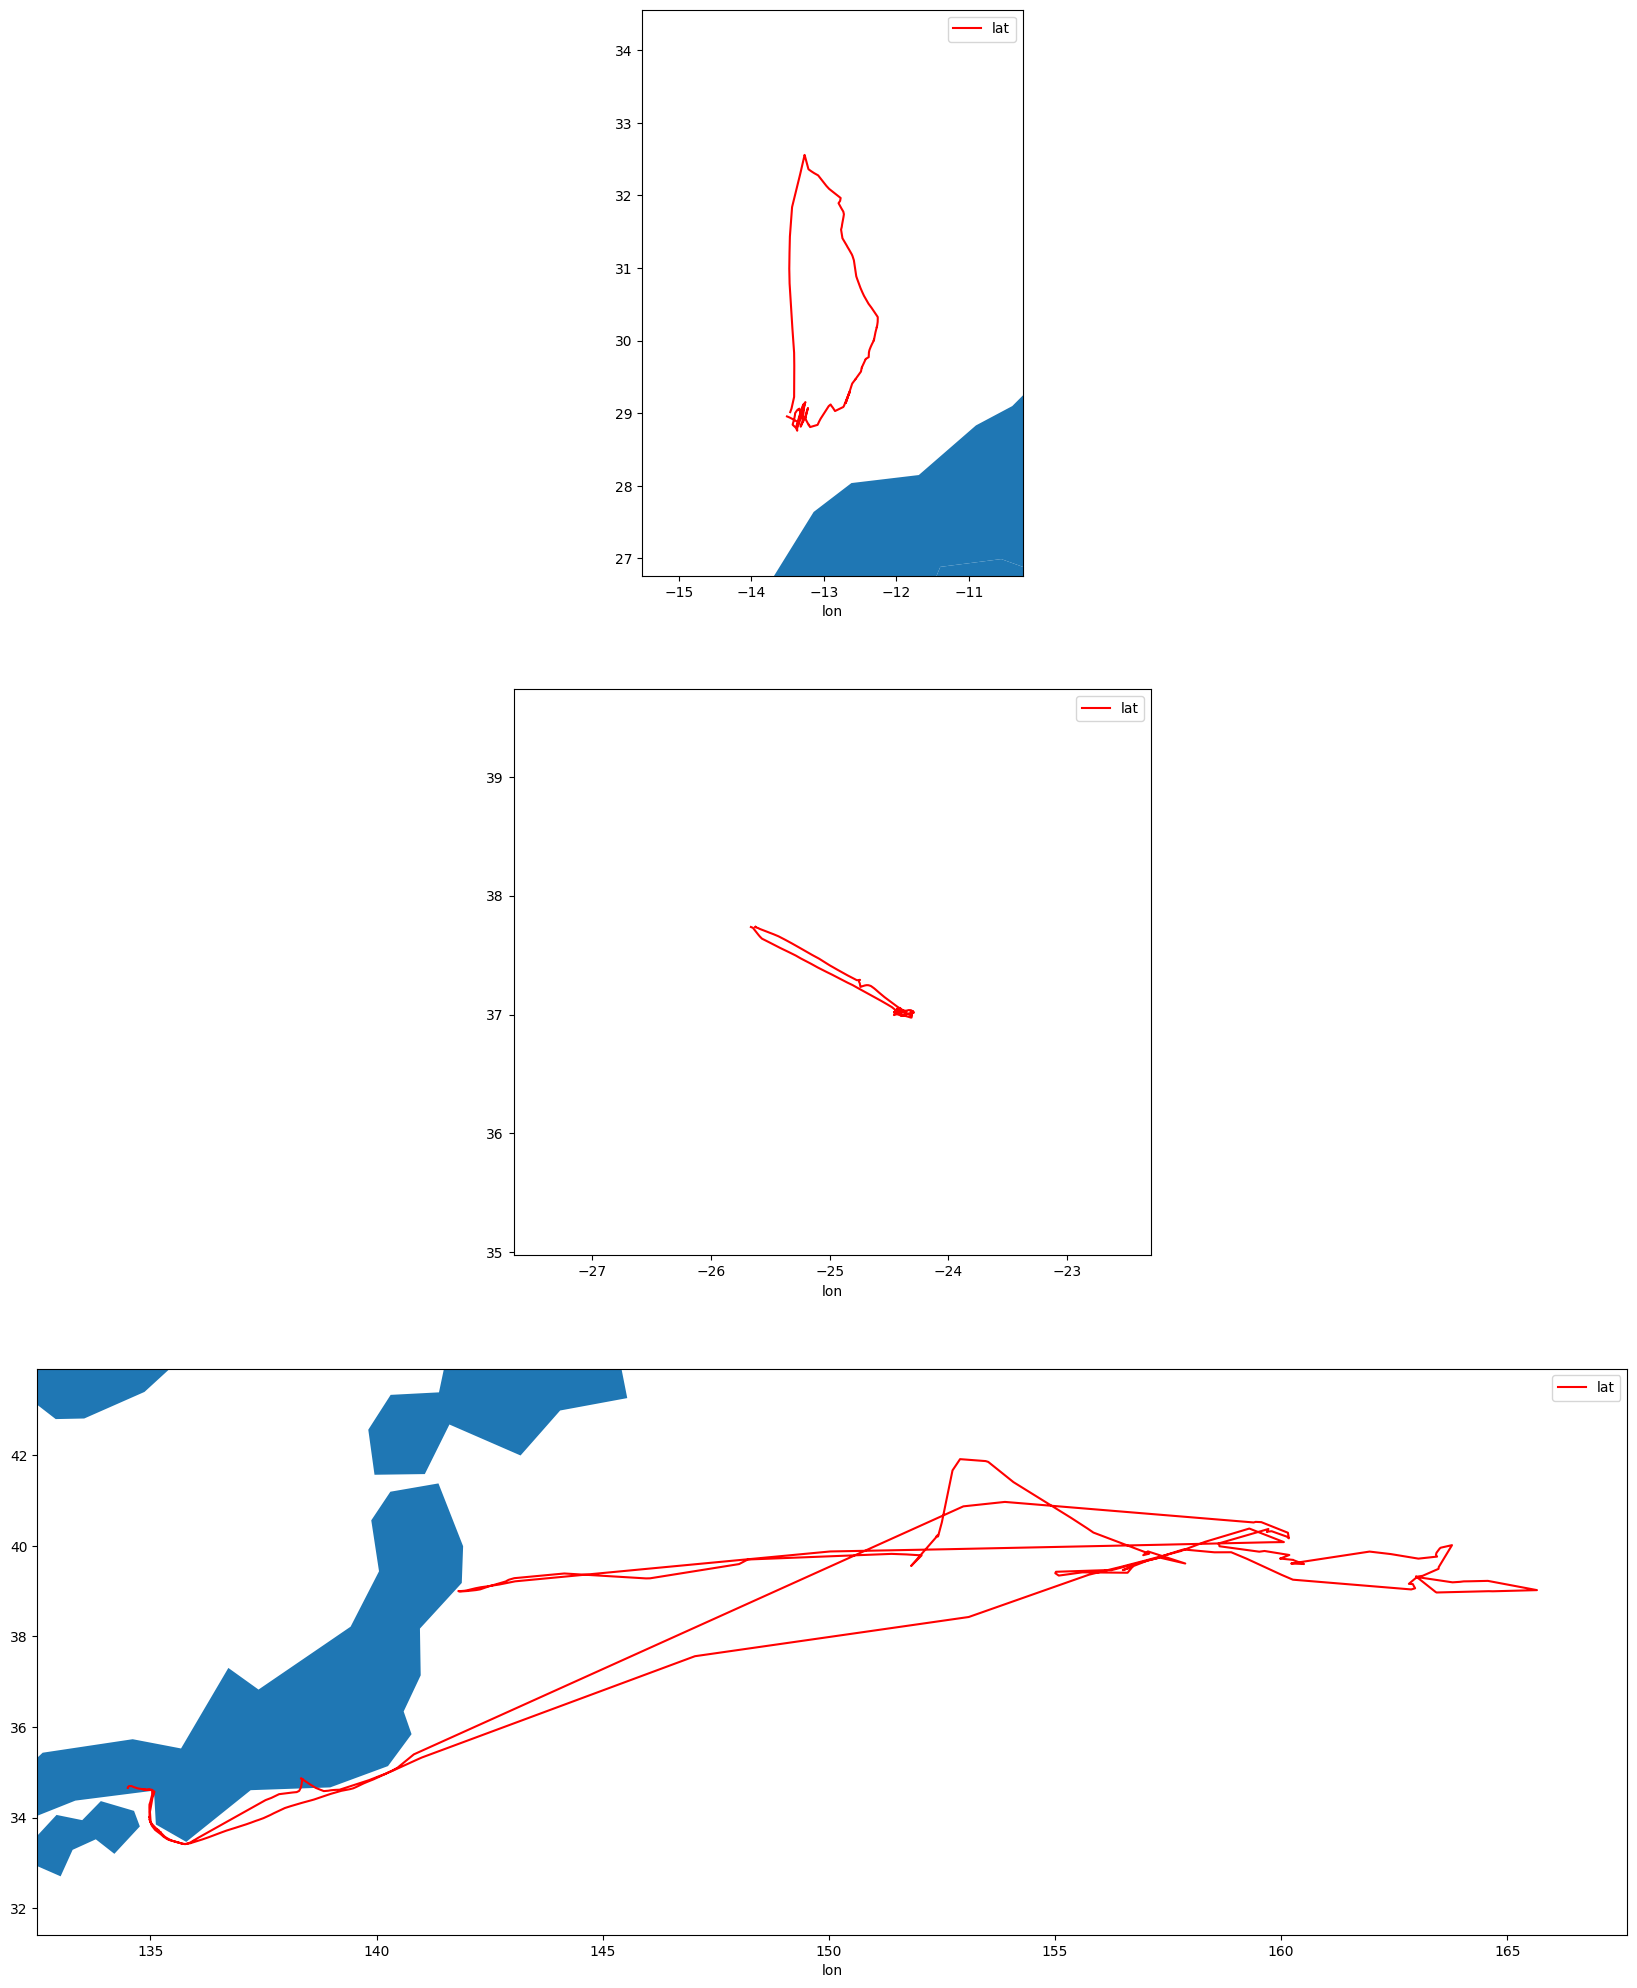

In [9]:
trips = len(ship_group)
fig, axes = plt.subplots(nrows=trips, figsize=(26,25))
world = gpd.read_file("data/geodata/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
boundary = 2

for ax ,group_entry in zip(axes.reshape(-1), ship_group):
    ship_df = group_entry[0]
    lon_max, lon_min = ship_df["lon"].max(), ship_df["lon"].min()
    lat_max, lat_min = ship_df["lat"].max(), ship_df["lat"].min()
    
    
    world.plot(ax=ax)
    ship_df.plot(x="lon",y="lat", kind="line", ax=ax, c="r")
    ax.set_ylim([lat_min-boundary,lat_max+boundary])
    ax.set_xlim([lon_min-boundary,lon_max+boundary])
#plt.show()